# Prediction of number of deaths/infected through COVID-19

This predictions are done on 18/04/2020, using data until this date.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from datetime import datetime,timedelta

## Data

The data comes from here: https://github.com/CSSEGISandData/COVID-19/

In [2]:
df_recovered=pd.read_csv('COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
df_recovered.head()


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,29,32,32,32,32,32,40,43,54,99
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,154,165,182,197,217,232,248,251,277,283
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,237,347,405,460,591,601,691,708,783,846
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,52,58,71,71,128,128,128,169,169,191
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,2,2,2,4,4,4,5,5,5,5


In [3]:
df_confirmed=pd.read_csv('COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df_confirmed.head()


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,444,484,521,555,607,665,714,784,840,906
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,400,409,416,433,446,467,475,494,518,539
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,1572,1666,1761,1825,1914,1983,2070,2160,2268,2418
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,564,583,601,601,638,646,659,673,673,696
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,19,19,19,19,19,19,19,19,19,19


In [4]:
df_dead=pd.read_csv('COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
df_dead.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,14,15,15,18,18,21,23,25,30,30
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,22,23,23,23,23,23,24,25,26,26
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,205,235,256,275,293,313,326,336,348,364
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,23,25,26,26,29,29,31,33,33,35
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2


## Data manipulation

So far, I pick up five different countries to study:

- China (The first one, and therefore the reference to compare to).
- Italy (One of the biggest ones, and much more similar in social, politics and size with other Europen countries).
- Spain
- France
- US (Summing all the data from all the states together).

In [5]:
df_confirmed.loc['WholeUS'] = df_confirmed[df_confirmed['Country/Region']=='US'].sum()
df_confirmed.loc[df_confirmed.index=='WholeUS','Country/Region']='WholeUS'
df_dead.loc['WholeUS'] = df_dead[df_dead['Country/Region']=='US'].sum()
df_dead.loc[df_dead.index=='WholeUS','Country/Region']='WholeUS'

In [6]:
df_confirmed.loc[df_confirmed.index=='WholeUS',:]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20
WholeUS,0,WholeUS,37.0902,-95.7129,1,1,2,2,5,5,...,429052,461437,496535,526396,555313,580619,607670,636350,667801,699706


In [7]:
df_confirmed[(df_confirmed['Country/Region']=='France') & (df_confirmed['Province/State'].isnull())]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20
116,NaN,France,46.2276,2.2137,0,0,2,3,3,3,...,82048,86334,90676,93790,120633,124298,130253,133470,145960,147969


In [8]:
def select_countries(df):
    df = df[(df['Country/Region']=='Spain') | (df['Country/Region']=='Italy') | 
                            ((df['Country/Region']=='France') & (df['Province/State'].isnull()))
                            |((df['Country/Region']=='China') & (df['Province/State']=='Hubei')) |
           (df['Country/Region']=='WholeUS')]
    return df

In [9]:
def prepare_dataframe(df,label='contagious'):
    """
    I create a new column "DayStart"+Country, which sets to 1 the day the number of contagious or deads equal the same as China on 1/22/20.
    This is done to be able to compare past curves (such as in China or Italy), with present ones (France, Spain or US)
    """
    if label=='contagious':
        nspain=43
        nfrance=42
        nitaly=34
        nus=44
    if label=='death':
        nspain=43
        nfrance=44
        nitaly=35
        nus=44
        
    df = df.set_index('Country/Region').drop(['Lat','Long','Province/State'],axis=1).T
    df = df.reset_index()
    df['DayStartChina']= df.index +1
    df['DayStartSpain']= df.index -nspain
    df['DayStartFrance']= df.index -nfrance
    df['DayStartItaly']= df.index -nitaly
    df['DayStartUS']= df.index -nus
    
    return df
        

In [10]:
df_contag  = select_countries(df_confirmed)
df_death  = select_countries(df_dead)

In [11]:
df_contag  = prepare_dataframe(df_contag,label='contagious')
df_death  = prepare_dataframe(df_death,label='death')

In [12]:
df_contag.head()

Country/Region,index,China,France,Italy,Spain,WholeUS,DayStartChina,DayStartSpain,DayStartFrance,DayStartItaly,DayStartUS
0,1/22/20,444,0,0,0,1,1,-43,-42,-34,-44
1,1/23/20,444,0,0,0,1,2,-42,-41,-33,-43
2,1/24/20,549,2,0,0,2,3,-41,-40,-32,-42
3,1/25/20,761,3,0,0,2,4,-40,-39,-31,-41
4,1/26/20,1058,3,0,0,5,5,-39,-38,-30,-40


## Model the data

As this is a Pandemic, we know it grows as an Exponential, until it reaches the inflexion point and it becomes a logistic function. I'm then going to consider both models for our analysis. 

In [13]:
def exponential_model(x,a,b,c):
    return a*np.exp(b*(x-c))

def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))


In [14]:
print(df_contag['Spain'].iloc[-1])

190839


In [15]:
def plot_normalized_day0(df,label='Contagious',fit=True):
    
    fig = plt.figure(figsize=(10,12))
    ax = fig.add_subplot(1, 1, 1)

    
    plt.plot(df['DayStartSpain'][df['DayStartSpain']>0],df['Spain'][df['DayStartSpain']>0],'b*')
    plt.plot(df['DayStartFrance'][df['DayStartFrance']>0],df['France'][df['DayStartFrance']>0],'yo')
    plt.plot(df['DayStartUS'][df['DayStartUS']>0],df['WholeUS'][df['DayStartUS']>0],'ms')
    plt.plot(df['DayStartItaly'][df['DayStartItaly']>0],df['Italy'][df['DayStartItaly']>0],'gv')
    plt.plot(df['DayStartChina'],df['China'],'r+')

    print('Last amount:')
    print('Spain ',df['Spain'].iloc[-1])
    print('France ',df['France'].iloc[-1])
    print('US ',df['WholeUS'].iloc[-1])
    print('Italy ',df['Italy'].iloc[-1])
    print('China ',df['China'].iloc[-1])

    if fit:
        xxS = np.array(df['DayStartSpain'][df['DayStartSpain']>0])
        yyS = np.array(df['Spain'][df['DayStartSpain']>0])
        xxSi=xxS[xxS<20]
        yySi=yyS[xxS<20]
        popt, pcov = curve_fit(exponential_model, xxSi, yySi, bounds=([-100,-1.,-100], [100., 1., 100.]))        
        poptS, pcovS = curve_fit(logistic_model, xxS, yyS, bounds=([1,10.,100], [10., 100., 1000000.]))
        plt.plot(xxSi, exponential_model(xxSi, *popt), 'b-')#
        plt.plot(xxS, logistic_model(xxS, *poptS), 'b--')#
        print('Spain Exponential fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
        print('Spain Logistic fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(poptS))

        xxF = np.array(df['DayStartFrance'][df['DayStartFrance']>0])
        yyF = np.array(df['France'][df['DayStartFrance']>0])
        xxFi=xxF[xxF<22]
        yyFi=yyF[xxF<22]
        popt, pcov = curve_fit(exponential_model, xxF, yyF, bounds=([-100,-1.,-100], [100., 1., 100.]))
        plt.plot(xxFi, exponential_model(xxFi, *popt), 'y-')#
        poptF, pcovF = curve_fit(logistic_model, xxF, yyF, bounds=([1,10.,100], [10., 100., 1000000.]))
        plt.plot(xxF, logistic_model(xxF, *poptF), 'y--')#
        print('France Exponential fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
        print('France Logistic fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(poptF))

        xxW = np.array(df['DayStartUS'][df['DayStartUS']>0])
        yyW = np.array(df['WholeUS'][df['DayStartUS']>0])
        xxWi=xxW[xxW<20]
        yyWi=yyW[xxW<20]        
        popt, pcov = curve_fit(exponential_model, xxWi, yyWi, bounds=([-100,-1.,-100], [100., 1., 100.]))
        plt.plot(xxWi, exponential_model(xxWi, *popt), 'm-')#
        poptW, pcovW = curve_fit(logistic_model, xxW, yyW, bounds=([1,10.,100], [10., 100., 1000000.]))
        plt.plot(xxW, logistic_model(xxW, *poptW), 'm--')#
        print('US Exponential fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
        print('US Logistic fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(poptW))

        xxI = np.array(df['DayStartItaly'][df['DayStartItaly']>0])
        yyI = np.array(df['Italy'][df['DayStartItaly']>0])
        xxIi=xxI[xxI<20]
        yyIi=yyI[xxI<20]
        popt, pcov = curve_fit(exponential_model, xxIi, yyIi) 
        plt.plot(xxIi, exponential_model(xxIi, *popt), 'g-')
        poptI, pcovI = curve_fit(logistic_model, xxI, yyI, bounds=([1,10.,100], [10., 100., 1000000.]))
        plt.plot(xxI, logistic_model(xxI, *poptI), 'g--')#
        print('Italy Exponential fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
        print('Italy Logistic fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(poptI))

        xxC = np.array(df['DayStartChina'])
        yyC = np.array(df['China'])
        xxCi=xxC[xxC<20]
        yyCi=yyC[xxC<20]
        popt, pcov = curve_fit(exponential_model, xxCi, yyCi) 
        plt.plot(xxCi, exponential_model(xxCi, *popt), 'r-')
        poptC, pcovC = curve_fit(logistic_model, xxC, yyC, bounds=([1,10.,100], [10., 100., 1000000.]))
        plt.plot(xxC, logistic_model(xxC, *poptC), 'r--')#
        print('China Exponential fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
        print('China Logistic fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(poptC))

    ax.set_yscale('log')
    plt.xticks(rotation=45)
    plt.legend(['Spain','France','US','Italy','China','Spain Exponential Model','Spain Logistic Model',
                'France Exponential Model','France Logistic Model','US Exponential Model','US Logistic Model',
            'Italy Exponential Model', 'Italy Logistic Model','China Exponential Model', 'China Logistic Model'])
    plt.xlabel('Day from start of multiple '+label)
    plt.ylabel('N '+label)
    plt.show()

Last amount:
Spain  190839
France  147969
US  699706
Italy  172434
China  68128
Spain Exponential fit: a=20.794, b=0.187, c=-21.683
Spain Logistic fit: a=5.615, b=26.107, c=189272.612
France Exponential fit: a=51.453, b=0.077, c=-60.915
France Logistic fit: a=8.724, b=39.606, c=236157.158
US Exponential fit: a=17.300, b=0.263, c=-12.551
US Logistic fit: a=5.569, b=31.747, c=783674.201
Italy Exponential fit: a=12.334, b=0.185, c=-22.123
Italy Logistic fit: a=7.232, b=31.732, c=174818.304
China Exponential fit: a=23.779, b=0.170, c=-23.587
China Logistic fit: a=4.264, b=19.699, c=67769.028


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


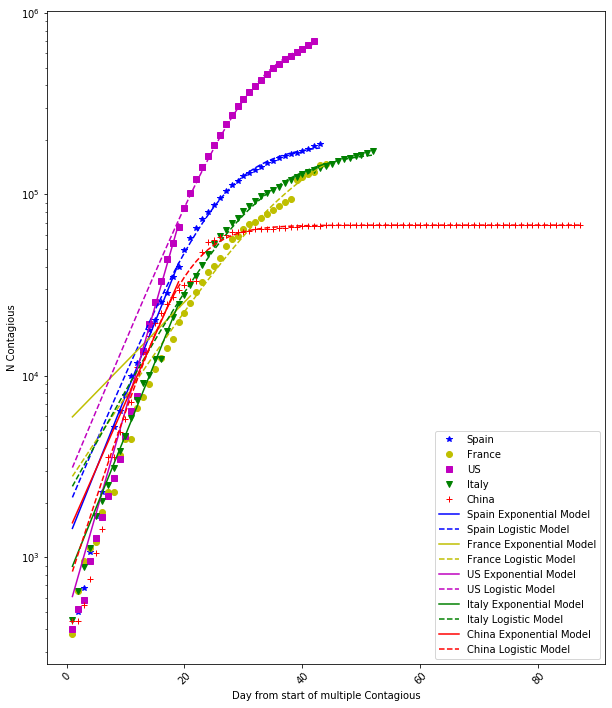

In [16]:
plot_normalized_day0(df_contag,label='Contagious')

Last amount:
Spain  20002
France  18681
US  36773
Italy  22745
China  4512
Spain Exponential fit: a=12.257, b=0.255, c=-2.458
Spain Logistic fit: a=5.235, b=28.026, c=20076.210
France Exponential fit: a=28.552, b=0.093, c=-29.383
France Logistic fit: a=5.028, b=32.380, c=20748.948
US Exponential fit: a=9.168, b=0.269, c=1.786
US Logistic fit: a=5.701, b=39.576, c=57718.900
Italy Exponential fit: a=8.738, b=0.224, c=-5.777
Italy Logistic fit: a=6.667, b=33.378, c=23262.827
China Exponential fit: a=11.917, b=0.160, c=-8.269
China Logistic fit: a=6.922, b=25.874, c=3206.156


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


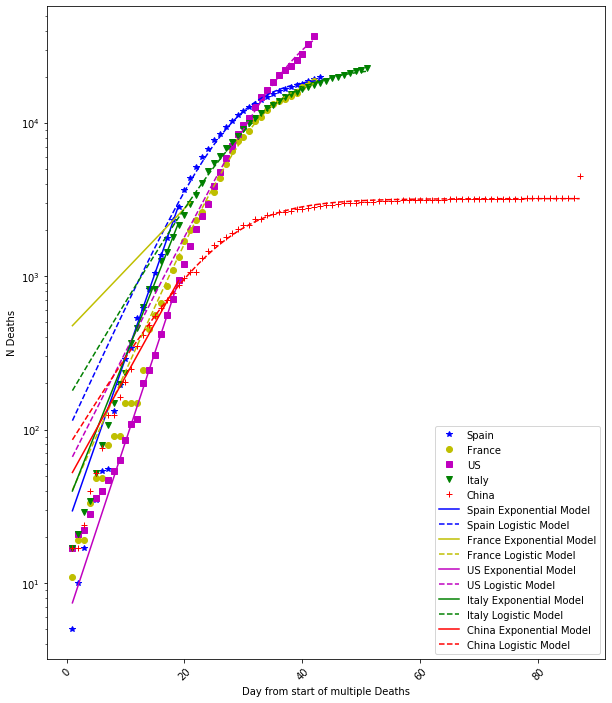

In [17]:
plot_normalized_day0(df_death,label='Deaths')

We have here fitted exponential and logistic models to the curves, and plot the above results. Let's notice than the deaths curves are much more realistic than the infected, as this depends very much on the existence of tests and different politics to measure those.

For the first time, countries such as Spain and France start to have a better logistic fit than exponential to date (31/03/2020).

## Extrapolation of the logistic model to 90 days after the first deaths/contagions

Let's use now only logistic models and assume there is going to be an inflection point of around ~25 days after the first contagions/deaths, to predict what will happen in 90 days after the first deaths / contagions.

Of course, this assumes that this inflection point is the same for all countries, and we know this will change depending on the strictness of the measurements that the different countries will take, so this is only a possible (and simple) scenario of what will happen.

In [18]:
def plot_extrapolated_logistic_model(df,label='Contagious',inflexion=25):
    
    fig = plt.figure(figsize=(10,12))
    ax = fig.add_subplot(1, 1, 1)

    
    plt.plot(df['DayStartSpain'][df['DayStartSpain']>0],df['Spain'][df['DayStartSpain']>0],'b*')
    plt.plot(df['DayStartFrance'][df['DayStartFrance']>0],df['France'][df['DayStartFrance']>0],'yo')
    plt.plot(df['DayStartUS'][df['DayStartUS']>0],df['WholeUS'][df['DayStartUS']>0],'ms')
    plt.plot(df['DayStartItaly'][df['DayStartItaly']>0],df['Italy'][df['DayStartItaly']>0],'gv')
    plt.plot(df['DayStartChina'],df['China'],'r+')

    xxPredictions = np.arange(0, 90)    
    
    xxS = np.array(df['DayStartSpain'][df['DayStartSpain']>0])
    yyS = np.array(df['Spain'][df['DayStartSpain']>0])
    popt, pcov = curve_fit(logistic_model, xxS, yyS, bounds=([1,inflexion-10,100], [10., inflexion+10, 1000000.]))       
#    popt, pcov = curve_fit(logistic_model, xxS, yyS, bounds=([1,10,100], [10., 100, 1000000.]))   
    
    plt.plot(xxPredictions, logistic_model(xxPredictions, popt[0],popt[1],popt[2]), 'b-')
    print('Spain',popt[0],popt[1],popt[2])
    print('Last expected amount 90 days before start:')
    print('Spain ',logistic_model(xxPredictions, popt[0],popt[1],popt[2])[-1])
    
    xxF = np.array(df['DayStartFrance'][df['DayStartFrance']>0])
    yyF = np.array(df['France'][df['DayStartFrance']>0])
    popt, pcov = curve_fit(logistic_model, xxF, yyF, bounds=([1,inflexion-10,100], [10., inflexion+10, 1000000.]))
#    popt, pcov = curve_fit(logistic_model, xxF, yyF, bounds=([4,1,100], [10., 100, 100000.]))
    plt.plot(xxPredictions, logistic_model(xxPredictions, popt[0],popt[1],popt[2]), 'y-')#
    print('France',popt[0],popt[1],popt[2])
    print('Last expected amount 90 days before start:')
    print('France ',logistic_model(xxPredictions, popt[0],popt[1],popt[2])[-1])
    
    xxW = np.array(df['DayStartUS'][df['DayStartUS']>0])
    yyW = np.array(df['WholeUS'][df['DayStartUS']>0])
    popt, pcov = curve_fit(logistic_model, xxW, yyW, bounds=([1,inflexion-10,100], [10., inflexion+10, 1000000.])) 
#    popt, pcov = curve_fit(logistic_model, xxW, yyW, bounds=([4,1,100], [10.,100, 1000000.])) 
    plt.plot(xxPredictions, logistic_model(xxPredictions, *popt), 'm-')#
    print('US',popt[0],popt[1],popt[2])
    print('Last expected amount 90 days before start:')
    print('US',logistic_model(xxPredictions, popt[0],popt[1],popt[2])[-1])
    
    xxI = np.array(df['DayStartItaly'][df['DayStartItaly']>0])
    yyI = np.array(df['Italy'][df['DayStartItaly']>0])
    popt, pcov = curve_fit(logistic_model, xxI, yyI, bounds=([1,inflexion-10,100], [10., inflexion+10, 1000000.]))
#    popt, pcov = curve_fit(logistic_model, xxI, yyI, bounds=([4,1,100], [10., 100, 1000000.]))
    plt.plot(xxPredictions, logistic_model(xxPredictions, popt[0],popt[1],popt[2]), 'g-')#
    print('Italy',popt[0],popt[1],popt[2])
    print('Last expected amount 90 days before start:')
    print('Italy ',logistic_model(xxPredictions, popt[0],popt[1],popt[2])[-1])
        
    xxC = np.array(df['DayStartChina'])
    yyC = np.array(df['China'])
    popt, pcov = curve_fit(logistic_model, xxC, yyC, bounds=([1,10,100], [10., 100, 100000.]))
#    popt, pcov = curve_fit(logistic_model, xxC, yyC, bounds=([4,1,100], [10., 100, 100000.]))
    plt.plot(xxPredictions, logistic_model(xxPredictions, popt[0],popt[1],popt[2]), 'r-')#
    print('China',popt[0],popt[1],popt[2])
    print('Last expected amount 90 days before start:')
    print('China ',logistic_model(xxPredictions, popt[0],popt[1],popt[2])[-1])

    
    ax.set_yscale('log')
    plt.xticks(rotation=45)
    plt.legend(['Spain','France','US','Italy','China','Spain Logistic Model','France Logistic Model',
                'US Logistic Model','Italy Logistic Model', 'China Logistic Model'])
    plt.xlabel('Day from start of multiple '+label)
    plt.ylabel('N '+label)
    plt.show()

Spain 5.6145779755003 26.106887305035958 189272.5524276655
Last expected amount 90 days before start:
Spain  189269.9688446189
France 8.308701310356218 37.99999999999999 215720.74125609026
Last expected amount 90 days before start:
France  215256.01896769827
US 5.568782823923128 31.747069017689093 783674.4709866028
Last expected amount 90 days before start:
US 783647.6102562847
Italy 7.232162804594111 31.73197607496579 174818.31559808413
Last expected amount 90 days before start:
Italy  174754.71525254007
China 4.264497124482306 19.69918147613069 67769.02791475458
Last expected amount 90 days before start:
China  67769.02197912458


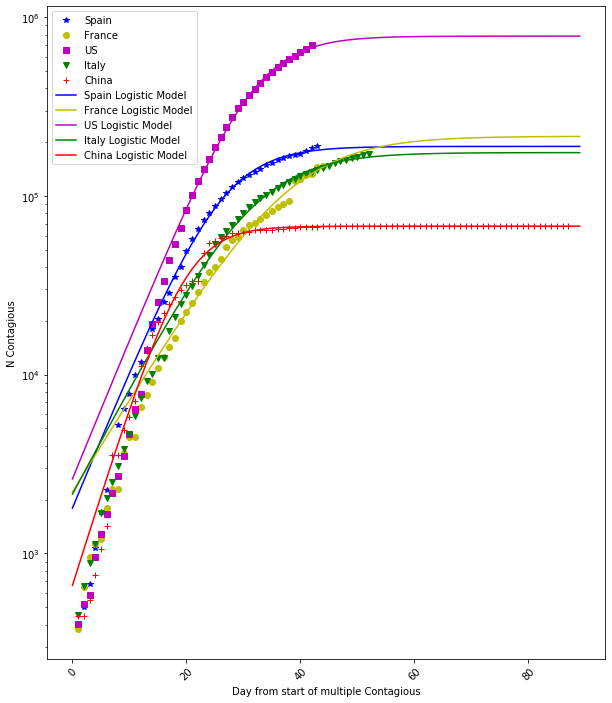

In [19]:
plot_extrapolated_logistic_model(df_contag,label='Contagious',inflexion=28)

Spain 5.235472139509851 28.025567945116066 20076.201113135703
Last expected amount 90 days before start:
Spain  20076.025438909062
France 5.028398042244716 32.38020401413318 20748.94658200645
Last expected amount 90 days before start:
France  20748.679384959192
US 5.296148726224594 37.99999999999999 50309.72995475827
Last expected amount 90 days before start:
US 50306.42226797397
Italy 6.6670170678312735 33.37762864399734 23262.813952932975
Last expected amount 90 days before start:
Italy  23257.276934592053
China 6.922106703884212 25.874218884378887 3206.1576687266356
Last expected amount 90 days before start:
China  3205.806583897383


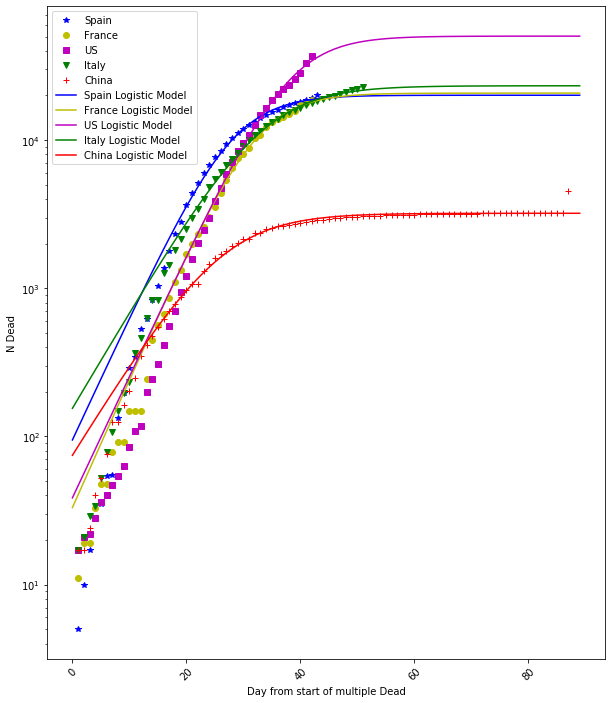

In [20]:
plot_extrapolated_logistic_model(df_death,label='Dead',inflexion=28)

I have used here, an inflexion point of 28 days for deaths, based on the data from Italy.  This might change or not, based on the different measures each country takes. Based on this, the predictions are:

- ~20000 deaths in Spain, ~ 23000 in Italy, ~21000 in France and ~50000 in the US (where the inflexion point is much higher ~38 days). In China, the official number of deaths are ~3000.
- The number of infected would be of the order of ~190.000 per Spain, 175.000 per Italy, 215.000 per France and ~780.000 for the US. China would have ~68.000. 
- Of course these numbers are based on the official number of infected and deaths but, this is very related to the different politics in terms of testing people and counting deaths due to CoronaVirus. Probably this is just a inferior limit.

## Things to do

- Add more countries
- Normalize by the population of each country / number of bed in hospitals per country.
- Try different scenarios (such as inflexion points)
- Continously update with new data (and hopefully expect that this will change!)